In [1]:
!pip install ott-jax>=0.2.4

### utils : Run this!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import grad, hessian, jit
from tqdm import tqdm
import time
import ott
from ott.geometry import geometry
from scipy.optimize import linear_sum_assignment

# from ott.core import sinkhorn, problems, linear_problems

class ConstrainedSinkhorn:
    """
    Implementation of Sinkhorn-type algorithm for Optimal Transport with linear constraints
    using OTT-JAX for geometry operations.
    """

    def __init__(self, C, r, c, D_list, thresholds, eta=1.0, max_iter=1000, tol=1e-6):
        """
        Initialize the constrained Sinkhorn algorithm.

        Parameters:
        -----------
        C : ndarray, shape (n, m)
            Cost matrix
        r : ndarray, shape (n,)
            Source distribution (marginal constraint)
        c : ndarray, shape (m,)
            Target distribution (marginal constraint)
        D_list : list of ndarray
            List of constraint matrices: [DI, DE]
            DI: inequality constraint matrix
            DE: equality constraint matrix
        thresholds : list of float
            Thresholds [tI, tE] for inequality and equality constraints
        eta : float
            Regularization parameter
        max_iter : int
            Maximum number of iterations
        tol : float
            Tolerance for convergence
        """
        # Convert inputs to JAX arrays
        self.C = jnp.array(C)
        self.r = jnp.array(r)
        self.c = jnp.array(c)
        self.D_list_orig = [jnp.array(D) for D in D_list]
        self.thresholds = thresholds

        # Process constraint matrices according to equation 13
        self.D_list = []
        # Inequality constraint: D1 = (DI - tI*1_{n×n})/n
        self.D_list.append((self.D_list_orig[0] - thresholds[0] * jnp.ones_like(self.C)) / self.C.shape[0])
        # Equality constraint: D2 = (DE - tE*1_{n×n})/n
        self.D_list.append((self.D_list_orig[1] - thresholds[1] * jnp.ones_like(self.C)) / self.C.shape[0])

        self.eta = eta
        self.max_iter = max_iter
        self.tol = tol

        self.n, self.m = C.shape
        self.K = 1  # Number of inequality constraints
        self.L = 1  # Number of equality constraints
        self.K_plus_L = self.K + self.L

        # Initialize dual variables
        self.x = jnp.zeros(self.n)
        self.y = jnp.zeros(self.m)
        self.a = jnp.zeros(self.K_plus_L)

        # For tracking convergence
        self.costs = []
        self.violations = []
        self.tv_distances = []
        self.iterations = []

        # Create OTT geometry for later use
        self.geom = geometry.Geometry(cost_matrix=self.C)

        # Store the true optimal solution (computed at the end)
        self.P_star_eta = None

    def _compute_P(self, x, y, a):
        """Compute the transport plan matrix P given dual variables x, y, a"""
        # Start with -C matrix
        logP = -self.C.copy()

        # Add contributions from constraint dual variables
        for i in range(self.K_plus_L):
            logP = logP + a[i] * self.D_list[i]

        # Add contributions from marginal dual variables
        logP = logP + x[:, jnp.newaxis]  # Add x to each column
        logP = logP + y[jnp.newaxis, :]  # Add y to each row

        # Apply eta and compute exp
        P = jnp.exp(self.eta * logP)

        return P

    def round_to_feasible(self, P):
        """
        Implementation of rounding algorithm from Altschuler et al. (2017)
        to project P onto the set of transport matrices U_{r,c}
        """
        """
        Round transport plan P to exactly satisfy marginals r and c.

        Parameters:
            P : np.ndarray, shape (n, m) - transport plan to be rounded
            r : np.ndarray, shape (n,)   - target row sums
            c : np.ndarray, shape (m,)   - target column sums

        Returns:
            P_hat : np.ndarray, shape (n, m) - rounded transport plan
        """
        n, m = P.shape

        # Step 1: Scale rows
        row_sums = P.sum(axis=1)
        u = np.minimum(1.0, self.r / (row_sums + 1e-12))  # Avoid divide-by-zero
        P_tilde = (u[:, None]) * P

        # Step 2: Scale columns
        col_sums = P_tilde.sum(axis=0)
        v = np.minimum(1.0, self.c / (col_sums + 1e-12))
        P_hat = P_tilde * v

        # Step 3: Residual correction
        residual_r = self.r - P_hat.sum(axis=1)
        residual_c = self.c - P_hat.sum(axis=0)
        correction = np.outer(residual_r, residual_c)
        correction = correction / np.sum(np.abs(residual_r))  # Normalize correction mass

        P_hat += correction
        return P_hat

    def compute_cost(self, P_rounded):
        """Compute the cost C·P for a rounded transport plan"""
        return jnp.sum(self.C * P_rounded)

    def compute_score(self, P_rounded):
        """Compute the score (-C)·P for a rounded transport plan"""
        return jnp.sum(-self.C * P_rounded)

    def compute_violation(self, P_rounded):
        """
        Compute constraint violation for a rounded transport plan:
        Violation(P) = |min(P·D_1, 0)| + |P·D_2|
        """
        # Inequality constraint violation: |min(P·D_1, 0)|
        ineq_violation = jnp.abs(jnp.minimum(jnp.sum(P_rounded * self.D_list_orig[0]), 0))

        # Equality constraint violation: |P·D_2 - t_E|
        eq_violation = jnp.abs(jnp.sum(P_rounded * self.D_list_orig[1]) - self.thresholds[1])

        return ineq_violation + eq_violation

    def compute_tv_distance(self, P, P_star):
        """Compute Total Variation distance between P and P_star"""
        return 0.5 * jnp.sum(jnp.abs(P - P_star))

    def dual_objective(self, x, y, a):
        """
        Compute the dual objective function f(x,y,a) as defined in equation 7
        This is the function we want to maximize
        """
        # Compute the first term related to P
        logP = -self.C.copy()
        for i in range(self.K_plus_L):
            logP = logP + a[i] * self.D_list[i]
        logP = logP + x[:, jnp.newaxis]
        logP = logP + y[jnp.newaxis, :]

        # First term
        term1 = -jnp.sum(jnp.exp(self.eta * logP)) / self.eta

        # Add dot products with marginals
        term2 = jnp.dot(x, self.r) + jnp.dot(y, self.c)

        # Add penalty terms for slack variables (the first K constraints)
        term3 = jnp.sum(jnp.exp(-self.eta * a[:self.K] - 1)) / self.eta if self.K > 0 else 0

        return term1 + term2 - term3

    def _gradient_a_t(self, a, t, x, y):
        """
        Compute the gradient of f with respect to a and t
        """
        # Current x with t shift
        x_t = x + t

        # Compute current P
        P = self._compute_P(x_t, y, a)

        # Initialize gradient
        grad = jnp.zeros(self.K_plus_L + 1)

        # Compute gradients for constraint dual variables
        for k in range(self.K):  # Inequality constraints
            grad = grad.at[k].set(-jnp.sum(P * self.D_list[k]) + jnp.exp(-self.eta * a[k] - 1))

        for l in range(self.K, self.K_plus_L):  # Equality constraints
            grad = grad.at[l].set(-jnp.sum(P * self.D_list[l]))

        # Gradient for t (normalization variable)
        grad = grad.at[-1].set(jnp.sum(self.r) - jnp.sum(P))

        return grad

    def _hessian_a_t(self, a, t, x, y):
        """
        Compute the Hessian of f with respect to a and t
        """
        # Current x with t shift
        x_t = x + t

        # Compute current P
        P = self._compute_P(x_t, y, a)

        # Initialize Hessian
        H = jnp.zeros((self.K_plus_L + 1, self.K_plus_L + 1))

        # Fill in the Hessian
        for i in range(self.K_plus_L):
            for j in range(self.K_plus_L):
                # H_ij = -eta * sum(P * D_i * D_j)
                H = H.at[i, j].set(-self.eta * jnp.sum(P * self.D_list[i] * self.D_list[j]))

            # Last column: derivative with respect to t
            H = H.at[i, -1].set(-self.eta * jnp.sum(P * self.D_list[i]))
            H = H.at[-1, i].set(-self.eta * jnp.sum(P * self.D_list[i]))  # Symmetry

        # Last diagonal element: derivative of t with respect to t
        H = H.at[-1, -1].set(-self.eta * jnp.sum(P))

        # Additional diagonal terms for slack variables (inequality constraints)
        for k in range(self.K):
            H = H.at[k, k].set(H[k, k] - self.eta * jnp.exp(-self.eta * a[k] - 1))

        return H

    def _a_t_update(self, x, y, a):
        """
        Perform the a,t update step using Newton's method
        """
        # Initial t value
        t = 0.0

        # Newton's method parameters
        max_iter = 50
        tol = 1e-6
        alpha = 0.5  # Backtracking line search parameter
        beta = 0.5   # Backtracking line search parameter

        for it in range(max_iter):
            # Compute gradient and Hessian
            grad = self._gradient_a_t(a, t, x, y)
            hess = self._hessian_a_t(a, t, x, y)

            # Compute Newton direction
            try:
                # Using numpy for numerical stability in solving linear system
                direction = -np.linalg.solve(np.array(hess), np.array(grad))
                direction = jnp.array(direction)
            except np.linalg.LinAlgError:
                # If Hessian is singular, use a regularized version
                reg_hess = hess + 1e-6 * jnp.eye(self.K_plus_L + 1)
                direction = -np.linalg.solve(np.array(reg_hess), np.array(grad))
                direction = jnp.array(direction)

            # Check for convergence
            if jnp.linalg.norm(grad) < tol:
                break

            # Backtracking line search
            step_size = 1.0
            a_dir = direction[:-1]
            t_dir = direction[-1]

            # Current objective value
            current_obj = self.dual_objective(x + t, y, a)

            while True:
                # Proposed new values
                a_new = a + step_size * a_dir
                t_new = t + step_size * t_dir

                # New objective value
                new_obj = self.dual_objective(x + t_new, y, a_new)

                # Check Armijo condition
                if new_obj >= current_obj + alpha * step_size * jnp.dot(grad, direction):
                    break

                # Reduce step size
                step_size *= beta

                # Break if step size becomes too small
                if step_size < 1e-10:
                    break

            # Update variables
            a = a + step_size * a_dir
            t = t + step_size * t_dir

        return a, t

    def compute_optimal_solution(self):
        """
        Compute the entropically optimal solution P⋆η by running the algorithm for many iterations
        """
        # Save current state
        x_save, y_save, a_save = self.x, self.y, self.a

        # Run for many iterations
        max_iter_save = self.max_iter
        self.max_iter = 10000  # Much more iterations to get close to optimal solution

        # Reset variables
        self.x = jnp.zeros(self.n)
        self.y = jnp.zeros(self.m)
        self.a = jnp.zeros(self.K_plus_L)

        # Run algorithm
        print("Computing optimal solution P⋆η...")
        self.solve(verbose=False, compute_metrics=False)

        # Store optimal solution
        P_star = self._compute_P(self.x, self.y, self.a)

        # Restore state
        self.x, self.y, self.a = x_save, y_save, a_save
        self.max_iter = max_iter_save

        return P_star

    def solve(self, verbose=True, compute_metrics=True, record_every=1):
        """
        Run the Sinkhorn-type algorithm to solve the constrained OT problem
        """
        # Compute P⋆η if needed and not already computed
        if compute_metrics and self.P_star_eta is None:
            self.P_star_eta = self.compute_optimal_solution()

        # Main optimization loop
        for it in range(self.max_iter):
            # Row scaling step
            P = self._compute_P(self.x, self.y, self.a)
            row_sums = P.sum(axis=1)
            self.x = self.x + (jnp.log(self.r) - jnp.log(row_sums)) / self.eta

            # Column scaling step
            P = self._compute_P(self.x, self.y, self.a)
            col_sums = P.sum(axis=0)
            self.y = self.y + (jnp.log(self.c) - jnp.log(col_sums)) / self.eta

            # Constraint dual update step using Newton's method
            self.a, t = self._a_t_update(self.x, self.y, self.a)
            self.x = self.x + t

            # Record metrics if needed
            if compute_metrics and it % record_every == 0:
                P = self._compute_P(self.x, self.y, self.a)
                P_rounded = self.round_to_feasible(P)

                # Compute cost, violation, and TV distance
                cost = self.compute_cost(P_rounded)
                violation = self.compute_violation(P_rounded)
                tv_distance = self.compute_tv_distance(P, self.P_star_eta)

                self.costs.append(float(cost))
                self.violations.append(float(violation))
                self.tv_distances.append(float(tv_distance))
                self.iterations.append(it)

                if verbose and it % (10 * record_every) == 0:
                    print(f"Iteration {it}: Cost = {cost:.6f}, Violation = {violation:.6f}, TV Distance = {tv_distance:.6f}")

            # Check convergence
            P = self._compute_P(self.x, self.y, self.a)
            row_error = jnp.linalg.norm(P.sum(axis=1) - self.r, ord=jnp.inf)
            col_error = jnp.linalg.norm(P.sum(axis=0) - self.c, ord=jnp.inf)

            # Check constraint satisfaction
            constraint_error = 0
            for i in range(self.K_plus_L):
                if i < self.K:  # Inequality constraint
                    constraint_error = max(constraint_error, jnp.sum(P * self.D_list[i]))
                else:  # Equality constraint
                    constraint_error = max(constraint_error, abs(jnp.sum(P * self.D_list[i])))

            # Overall error
            error = max(float(row_error), float(col_error), float(constraint_error))

            if error < self.tol:
                if verbose:
                    print(f"Converged after {it+1} iterations with error {error}")
                break

        # Return final transport plan and dual variables
        P = self._compute_P(self.x, self.y, self.a)
        P_rounded = self.round_to_feasible(P)

        return P, P_rounded, {"x": self.x, "y": self.y, "a": self.a}

    def plot_results(self):
        """Plot the results of the algorithm"""
        if not self.costs or not self.violations or not self.tv_distances:
            print("No metrics to plot. Run solve() with compute_metrics=True first.")
            return

        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot 1: Cost and Constraint Violation
        ax1.set_title('Assignment Cost and Constraint Violation')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Value')

        # Plot cost
        lns1 = ax1.plot(self.iterations, self.costs, 'b-', label='Cost')
        ax1.set_yscale('log')

        # Create second y-axis for violations
        ax1_2 = ax1.twinx()
        ax1_2.set_ylabel('Constraint Violation')
        lns2 = ax1_2.plot(self.iterations, self.violations, 'r-', label='Violation')
        ax1_2.set_yscale('log')

        # Add legend
        lns = lns1 + lns2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc='upper right')

        # Plot 2: TV Distance
        ax2.set_title('TV Distance to Entropically Optimal Solution')
        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('TV Distance')
        ax2.plot(self.iterations, self.tv_distances, 'g-')
        ax2.set_yscale('log')

        plt.tight_layout()
        plt.show()

        return fig


# Helper functions for the Pareto front experiment

def compute_pareto_front(C1, C2, r, c, eta_values, t_range, num_points=10):
    """
    Compute the Pareto front between Manhattan and Euclidean distance costs.

    Args:
        C1: Manhattan distance cost matrix
        C2: Euclidean distance cost matrix
        r: Source distribution
        c: Target distribution
        eta_values: List of entropy regularization parameters
        t_range: Range of constraint thresholds [t_min, t_max]
        num_points: Number of points on the Pareto front

    Returns:
        pareto_fronts: List of Pareto fronts for each eta value
        t_values: Constraint threshold values used
    """
    # Generate t values for the Pareto front
    t_min, t_max = t_range
    t_values = np.linspace(t_min, t_max, num_points)

    # Initialize results storage
    pareto_fronts = []

    # For each eta value
    for eta in eta_values:
        print(f"\nComputing Pareto front for eta = {eta}")
        eta_front = []

        # For each constraint threshold
        for t in tqdm(t_values):
            # Setup constraint: minimize Manhattan cost (C1)
            # subject to Euclidean cost (C2) <= t

            # Create solver
            solver = ConstrainedSinkhorn(
                C=C1,  # Minimize Manhattan cost
                r=r,
                c=c,
                D_list=[C2, np.zeros_like(C1)],  # C2 as inequality constraint, dummy equality constraint
                thresholds=[t, 0.0],  # t as threshold for C2, 0 for dummy equality
                eta=eta,
                max_iter=100,
                tol=1e-5
            )

            # Solve with minimal metrics tracking to save time
            P, P_rounded, _ = solver.solve(verbose=False, compute_metrics=False)

            # Compute costs for the rounded solution
            manhattan_cost = np.sum(C1 * P_rounded)
            euclidean_cost = np.sum(C2 * P_rounded)

            # Store results
            eta_front.append((float(manhattan_cost), float(euclidean_cost)))
            print(f"  t = {t:.4f}: Manhattan = {manhattan_cost:.6f}, Euclidean = {euclidean_cost:.6f}")

        # Store front for this eta
        pareto_fronts.append((eta, eta_front))

    return pareto_fronts, t_values

def plot_pareto_front(pareto_fronts, eta_values):
    """
    Plot the Pareto front for different entropy regularization parameters.

    Args:
        pareto_fronts: List of Pareto fronts
        eta_values: List of eta values corresponding to each front

    Returns:
        fig: Figure object
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Colors and markers for different eta values
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    markers = ['o', 's', 'd', '^', 'v', '<']

    # Plot each Pareto front
    for i, (eta, front) in enumerate(pareto_fronts):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]

        manhattan_costs, euclidean_costs = zip(*front)
        ax.plot(manhattan_costs, euclidean_costs, f'{color}-',
                marker=marker, markersize=8, label=f'η = {eta}')

    # Extract all points from all fronts for reference
    all_points = []
    for _, front in pareto_fronts:
        all_points.extend(front)

    # Sort by Manhattan cost (x-coordinate)
    all_points.sort()

    # Add labels and title
    ax.set_xlabel('Manhattan $\ell_1$ Transport Cost', fontsize=14)
    ax.set_ylabel('Euclidean $\ell_2$ Transport Cost', fontsize=14)
    ax.set_title('Pareto Front: Euclidean vs. Manhattan Distance', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12)

    plt.tight_layout()

    return fig


# Helper functions for the Pareto front experiment

def compute_pareto_front(C1, C2, r, c, eta_values, t_range, num_points=10):
    """
    Compute the Pareto front between Manhattan and Euclidean distance costs.

    Args:
        C1: Manhattan distance cost matrix
        C2: Euclidean distance cost matrix
        r: Source distribution
        c: Target distribution
        eta_values: List of entropy regularization parameters
        t_range: Range of constraint thresholds [t_min, t_max]
        num_points: Number of points on the Pareto front

    Returns:
        pareto_fronts: List of Pareto fronts for each eta value
        t_values: Constraint threshold values used
    """
    # Generate t values for the Pareto front
    t_min, t_max = t_range
    t_values = np.linspace(t_min, t_max, num_points)

    # Initialize results storage
    pareto_fronts = []

    # For each eta value
    for eta in eta_values:
        print(f"\nComputing Pareto front for eta = {eta}")
        eta_front = []

        # For each constraint threshold
        for t in tqdm(t_values):
            # Setup constraint: minimize Manhattan cost (C1)
            # subject to Euclidean cost (C2) <= t

            # Create solver
            solver = ConstrainedSinkhorn(
                C=C1,  # Minimize Manhattan cost
                r=r,
                c=c,
                D_list=[C2, np.zeros_like(C1)],  # C2 as inequality constraint, dummy equality constraint
                thresholds=[t, 0.0],  # t as threshold for C2, 0 for dummy equality
                eta=eta,
                max_iter=100,
                tol=1e-5
            )

            # Solve with minimal metrics tracking to save time
            P, P_rounded, _ = solver.solve(verbose=False, compute_metrics=False)

            # Compute costs for the rounded solution
            manhattan_cost = np.sum(C1 * P_rounded)
            euclidean_cost = np.sum(C2 * P_rounded)

            # Store results
            eta_front.append((float(manhattan_cost), float(euclidean_cost)))
            print(f"  t = {t:.4f}: Manhattan = {manhattan_cost:.6f}, Euclidean = {euclidean_cost:.6f}")

        # Store front for this eta
        pareto_fronts.append((eta, eta_front))

    return pareto_fronts, t_values

def plot_pareto_front(pareto_fronts, eta_values):
    """
    Plot the Pareto front for different entropy regularization parameters.

    Args:
        pareto_fronts: List of Pareto fronts
        eta_values: List of eta values corresponding to each front

    Returns:
        fig: Figure object
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Colors and markers for different eta values
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    markers = ['o', 's', 'd', '^', 'v', '<']

    # Plot each Pareto front
    for i, (eta, front) in enumerate(pareto_fronts):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]

        manhattan_costs, euclidean_costs = zip(*front)
        ax.plot(manhattan_costs, euclidean_costs, f'{color}-',
                marker=marker, markersize=8, label=f'η = {eta}')

    # Extract all points from all fronts for reference
    all_points = []
    for _, front in pareto_fronts:
        all_points.extend(front)

    # Sort by Manhattan cost (x-coordinate)
    all_points.sort()

    # Add labels and title
    ax.set_xlabel('Manhattan $\ell_1$ Transport Cost', fontsize=14)
    ax.set_ylabel('Euclidean $\ell_2$ Transport Cost', fontsize=14)
    ax.set_title('Pareto Front: Euclidean vs. Manhattan Distance', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12)

    plt.tight_layout()

    return fig

In [3]:
def generate_geometric_transport_data(n=100, dim=2, seed=42):
    """
    Generate data for the geometric transport problem as described in section 5.

    Args:
        n: Number of points in source and target distributions
        dim: Dimension of the space (2 for 2D points)
        seed: Random seed for reproducibility

    Returns:
        C1: Manhattan distance cost matrix
        C2: Euclidean distance cost matrix
        r: Source distribution (uniform)
        c: Target distribution (uniform)
        source_points: Source points in 2D space
        target_points: Target points in 2D space
    """
    # Set random seed
    np.random.seed(seed)

    # Generate random points in 2D space
    source_points = np.random.uniform(0, 1, (n, dim))
    target_points = np.random.uniform(0, 1, (n, dim))

    # Uniform distributions
    r = np.ones(n) / n
    c = np.ones(n) / n

    # Compute Manhattan distance cost matrix
    C1 = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # L1 norm (Manhattan distance)
            C1[i, j] = np.sum(np.abs(source_points[i] - target_points[j]))

    # Compute Euclidean distance cost matrix
    C2 = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # L2 norm (Euclidean distance)
            C2[i, j] = np.sqrt(np.sum((source_points[i] - target_points[j])**2))

    return C1, C2, r, c, source_points, target_points

In [4]:
# Constrained Optimal Transport with OTT-JAX
# Tutorial Notebook

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm.notebook import tqdm

# Import OTT libraries
import ott
from ott.geometry import geometry
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem

# Import utility functions for constrained OT from utils.py
# Most implementation details are in the utils.py file
# from utils import (
#     ConstrainedSinkhorn,
#     generate_geometric_transport_data,
#     compute_pareto_front,
#     plot_pareto_front
# )

# Set random seed for reproducibility
np.random.seed(42)

# Introduction to Optimal Transport
 Before this final version notebook, our first attempt was something completely different. We started by subclassing the Sinkhorn class from OTT-JAX, aiming to adapt it for linear constraints. We attempted to make a Sinkhorn-like algorithm by leveraging the existing structure, specifically trying to handle the standard row/column scaling  by using the equivalent one kernel update step by inheriting or adapting kernel_step from Sinkhorn class. We encountered issues in the main loop as the underlying OTT-JAX Sinkhorn implementation relies on a fixed_point_loop instead of a more easily understandable and straightforward loop. This fixed_point_loop is a specific JAX construct used to enable features like automatic differentiation and compilation, which added complexity compared to a direct iterative loop.

 Optimal Transport (OT) is a mathematical framework for comparing probability distributions by finding the most efficient way to transform one distribution into another. Classic OT problems involve minimizing the transportation cost between two distributions, subject to marginal constraints.

 In this tutorial, we explore *constrained* optimal transport, where additional constraints beyond the marginals are imposed on the transport plan.

 We'll use OTT-JAX, a powerful library for optimal transport that leverages JAX for efficient computation.


## Regular Optimal Transport with OTT-JAX

Let's start by solving a standard OT problem using OTT-JAX.

/usr/local/lib/python3.11/dist-packages/ott/solvers/linear/sinkhorn.py:924: UserWarning: Explicitly requested dtype float64 requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  errors = -jnp.ones((self.outer_iterations, len(self.norm_error)),
/usr/local/lib/python3.11/dist-packages/ott/solvers/linear/sinkhorn.py:881: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda *_: jnp.array(jnp.inf, dtype=ot_prob.dtype),


Standard OT cost: 0.023201


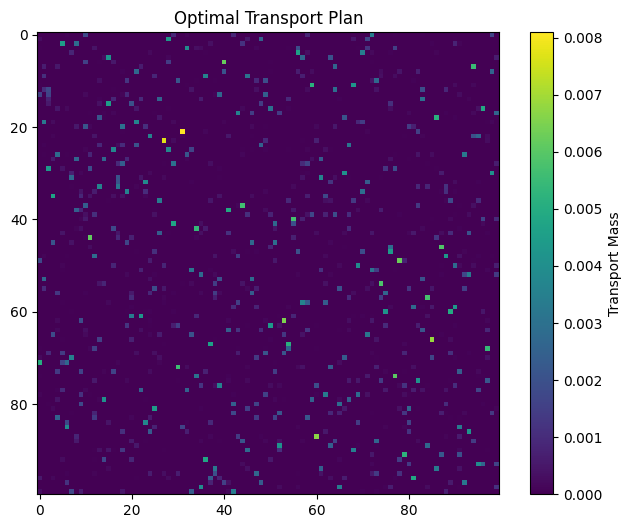

In [5]:
# First, we'll generate some random data:

# %%
# Generate random cost matrix and distributions
n = 100  # Size of the problem (number of points)
C = np.random.uniform(0, 1, (n, n))  # Random cost matrix
r = np.ones(n) / n  # Uniform source distribution
c = np.ones(n) / n  # Uniform target distribution

# Let's solve a standard OT problem using OTT-JAX
# Create OTT geometry with the cost matrix
geom = geometry.Geometry(cost_matrix=C)

# Create OTT problem
problem = linear_problem.LinearProblem(geom, a=jnp.array(r), b=jnp.array(c))

# Create OTT solver and solve
solver = sinkhorn.Sinkhorn(threshold=1e-6, max_iterations=1000)
ot_solution = solver(problem)

# Extract transport plan and compute cost
P = ot_solution.matrix
cost = np.sum(C * P)

print(f"Standard OT cost: {cost:.6f}")

# Visualize the transport plan
plt.figure(figsize=(8, 6))
plt.imshow(P, cmap='viridis')
plt.colorbar(label='Transport Mass')
plt.title('Optimal Transport Plan')
plt.show()


## Constrained Optimal Transport

Now, let's explore the more interesting case of constrained optimal transport.

The standard OT problem minimizes the cost $\langle C, P \rangle$ subject to marginal constraints:
$P \mathbf{1} = r$ and $P^T \mathbf{1} = c$.

In constrained OT, we add additional constraints of the form:
- Inequality constraint: $\langle D^I, P \rangle \leq t^I$
- Equality constraint: $\langle D^E, P \rangle = t^E$

where $D^I$ and $D^E$ are constraint matrices, and $t^I$ and $t^E$ are thresholds.

We'll implement a Sinkhorn-type algorithm for solving constrained OT problems. The core algorithm (based on the Constrained Sinkhorn algorithm from paper [1]) is shown below:


In [6]:
# Algorithm 1: Constrained Sinkhorn

def solve_constrained_ot(C, r, c, D_list, thresholds, eta=1.0, max_iter=1000, tol=1e-6):
    """
    Implementation of Algorithm 1: Constrained Sinkhorn

    Parameters:
    -----------
    C : ndarray, shape (n, m)
        Cost matrix
    r : ndarray, shape (n,)
        Source distribution (marginal constraint)
    c : ndarray, shape (m,)
        Target distribution (marginal constraint)
    D_list : list of ndarray
        List of constraint matrices: [DI, DE]
        DI: inequality constraint matrix
        DE: equality constraint matrix
    thresholds : list of float
        Thresholds [tI, tE] for inequality and equality constraints
    eta : float
        Regularization parameter
    max_iter : int
        Maximum number of iterations
    tol : float
        Tolerance for convergence
    """
    # Initialize the solver with our problem data
    solver = ConstrainedSinkhorn(
        C=C, r=r, c=c, D_list=D_list, thresholds=thresholds,
        eta=eta, max_iter=max_iter, tol=tol
    )

    # The ConstrainedSinkhorn.solve method implements Algorithm 1
    # This method alternates between:
    # 1. Row scaling step (ensuring row marginals match r)
    # 2. Column scaling step (ensuring column marginals match c)
    # 3. Constraint dual update using Newton's method
    P, P_rounded, duals = solver.solve(verbose=True, compute_metrics=True)

    return P, P_rounded, solver


## Experiment 1: Basic Constrained OT Problem

Let's reproduce experiment 1 from the paper[1]:



Computing optimal solution P⋆η...
Iteration 0: Cost = 0.119307, Violation = 0.000111, TV Distance = 0.315029
Iteration 10: Cost = 0.043519, Violation = 0.001596, TV Distance = 0.118930
Iteration 20: Cost = 0.028379, Violation = 0.000810, TV Distance = 0.067216
Iteration 30: Cost = 0.022771, Violation = 0.000733, TV Distance = 0.040975
Iteration 40: Cost = 0.020223, Violation = 0.000507, TV Distance = 0.025816


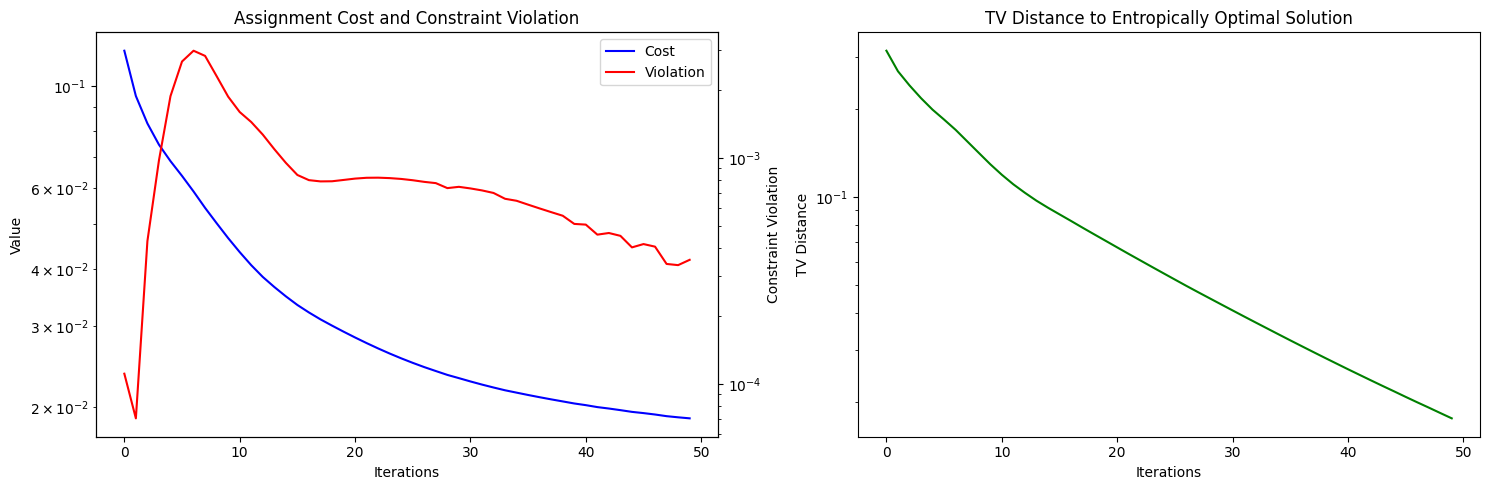

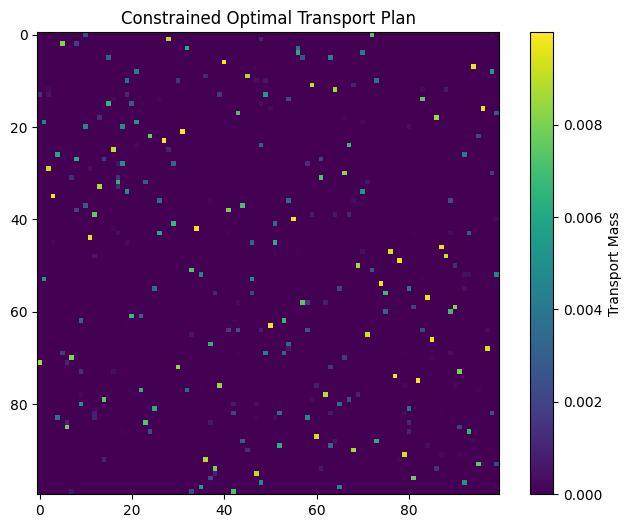

Final cost: 0.018930
Inequality constraint violation: 0.000000
Equality constraint violation: 0.000354


In [7]:

n = 100
np.random.seed(42)

# Random cost matrix and constraint matrices
C = np.random.uniform(0, 1, (n, n))
DI = np.random.uniform(0, 1, (n, n))  # Inequality constraint matrix
DE = np.random.uniform(0, 1, (n, n))  # Equality constraint matrix

# Uniform distributions
r = np.ones(n) / n
c = np.ones(n) / n

# Thresholds for constraints
tI = 0.5  # Threshold for inequality constraint
tE = 0.5  # Threshold for equality constraint

# Solve constrained OT
eta = 500  # Regularization parameter
P, P_rounded, solver = solve_constrained_ot(
    C=C, r=r, c=c,
    D_list=[DI, DE],
    thresholds=[tI, tE],
    eta=eta,
    max_iter=50
)

# Plot results and convergence
solver.plot_results()

# Plot the transport plan
plt.figure(figsize=(8, 6))
plt.imshow(P_rounded, cmap='viridis')
plt.colorbar(label='Transport Mass')
plt.title('Constrained Optimal Transport Plan')
plt.show()

# Compute costs and constraint violations
cost = np.sum(C * P_rounded)
ineq_violation = np.abs(np.minimum(np.sum(P_rounded * DI) - tI, 0))
eq_violation = np.abs(np.sum(P_rounded * DE) - tE)

print(f"Final cost: {cost:.6f}")
print(f"Inequality constraint violation: {ineq_violation:.6f}")
print(f"Equality constraint violation: {eq_violation:.6f}")


## Experiment 2: Geometric Transport Problem and Pareto Front

Now let's explore a more interesting application: the geometric transport problem with Manhattan and Euclidean distance costs.

We'll compute the Pareto front between these two costs, which allows us to visualize the trade-off between minimizing Manhattan distance vs. Euclidean distance.


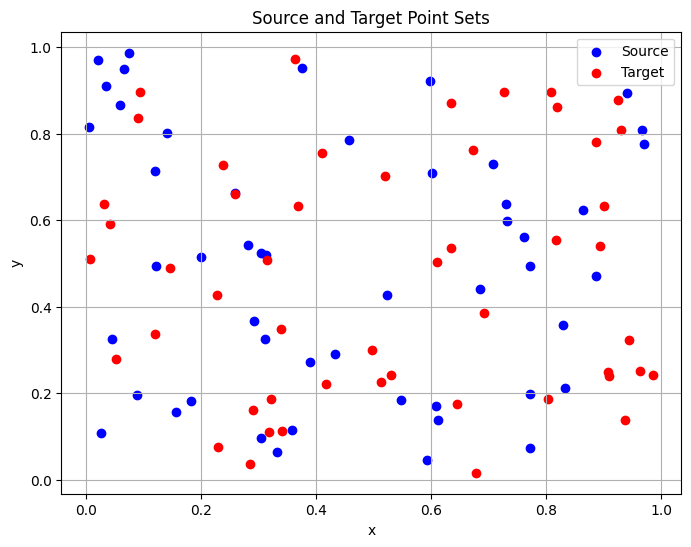

Manhattan-optimal transport plan:
  Manhattan cost: 0.163026
  Euclidean cost: 0.137401
Euclidean-optimal transport plan:
  Manhattan cost: 0.167159
  Euclidean cost: 0.133850

Computing Pareto front for eta = 10


  0%|          | 0/8 [00:00<?, ?it/s]

  t = 0.1272: Manhattan = 0.234180, Euclidean = 0.191981
  t = 0.1296: Manhattan = 0.234187, Euclidean = 0.191986
  t = 0.1320: Manhattan = 0.234193, Euclidean = 0.191992
  t = 0.1345: Manhattan = 0.234200, Euclidean = 0.191998
  t = 0.1369: Manhattan = 0.234207, Euclidean = 0.192004
  t = 0.1394: Manhattan = 0.234215, Euclidean = 0.192010
  t = 0.1418: Manhattan = 0.234223, Euclidean = 0.192017
  t = 0.1443: Manhattan = 0.234231, Euclidean = 0.192024

Computing Pareto front for eta = 100


  0%|          | 0/8 [00:00<?, ?it/s]

  t = 0.1272: Manhattan = 0.175831, Euclidean = 0.147673
  t = 0.1296: Manhattan = 0.175143, Euclidean = 0.147902
  t = 0.1320: Manhattan = 0.174669, Euclidean = 0.148343
  t = 0.1345: Manhattan = 0.174377, Euclidean = 0.148957
  t = 0.1369: Manhattan = 0.174230, Euclidean = 0.149709
  t = 0.1394: Manhattan = 0.174197, Euclidean = 0.150556
  t = 0.1418: Manhattan = 0.174271, Euclidean = 0.151479
  t = 0.1443: Manhattan = 0.174447, Euclidean = 0.152469


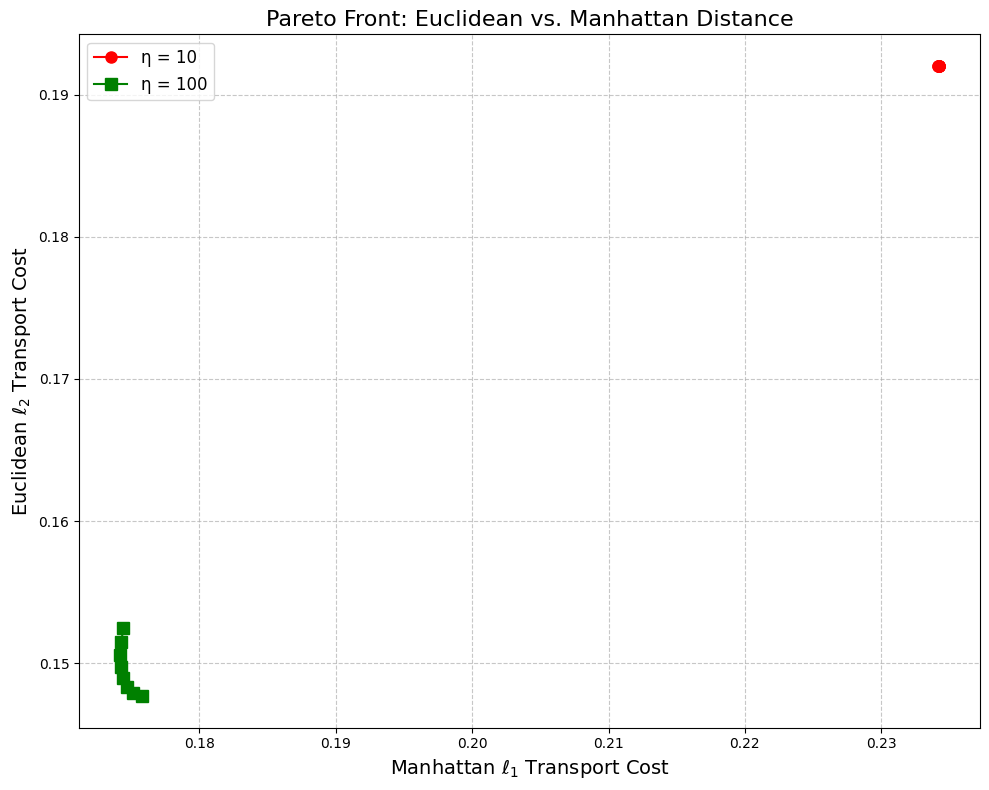

In [10]:

n = 50  # Number of points
C1, C2, r, c, source_points, target_points = generate_geometric_transport_data(n=n)

# Visualize the point sets
plt.figure(figsize=(8, 6))
plt.scatter(source_points[:, 0], source_points[:, 1], color='blue', label='Source')
plt.scatter(target_points[:, 0], target_points[:, 1], color='red', label='Target')
plt.legend()
plt.title('Source and Target Point Sets')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# Solve standard OT with Manhattan distance cost
geom1 = geometry.Geometry(cost_matrix=C1)
problem1 = linear_problem.LinearProblem(geom1, a=jnp.array(r), b=jnp.array(c))
solver1 = sinkhorn.Sinkhorn(threshold=1e-6, max_iterations=1000)
ot_solution1 = solver1(problem1)
P1 = ot_solution1.matrix
manhattan_cost = np.sum(C1 * P1)
euclidean_cost_at_manhattan = np.sum(C2 * P1)

# Solve standard OT with Euclidean distance cost
geom2 = geometry.Geometry(cost_matrix=C2)
problem2 = linear_problem.LinearProblem(geom2, a=jnp.array(r), b=jnp.array(c))
solver2 = sinkhorn.Sinkhorn(threshold=1e-6, max_iterations=1000)
ot_solution2 = solver2(problem2)
P2 = ot_solution2.matrix
manhattan_cost_at_euclidean = np.sum(C1 * P2)
euclidean_cost = np.sum(C2 * P2)

print(f"Manhattan-optimal transport plan:")
print(f"  Manhattan cost: {manhattan_cost:.6f}")
print(f"  Euclidean cost: {euclidean_cost_at_manhattan:.6f}")
print(f"Euclidean-optimal transport plan:")
print(f"  Manhattan cost: {manhattan_cost_at_euclidean:.6f}")
print(f"  Euclidean cost: {euclidean_cost:.6f}")

# %%
# Compute Pareto front with different regularization parameters
eta_values = [10,100]  # Regularization parameters
t_range = [0.95 * euclidean_cost, 1.05 * euclidean_cost_at_manhattan]
num_points = 8

# This might take some time to compute
pareto_fronts, t_values = compute_pareto_front(
    C1, C2, r, c, eta_values, t_range, num_points
)

# Plot the Pareto front
fig = plot_pareto_front(pareto_fronts, eta_values)
plt.show()


## Conclusion

In this tutorial, we've explored constrained optimal transport using OTT-JAX. We've seen:

1. How to solve standard OT problems using OTT-JAX
2. How to formulate and solve constrained OT problems
3. An application to geometric transport with multiple costs (Manhattan and Euclidean)

Constrained optimal transport provides a powerful framework for solving transport problems with additional requirements beyond the standard marginal constraints.

The implementation details of the `ConstrainedSinkhorn` class and helper functions can be found in the `utils`. The core algorithm follows a Sinkhorn-type approach with alternating row/column scaling and constraint dual updates.

## References
[1] : https://doi.org/10.48550/arXiv.2403.05054
